
# Assignment Set 9

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU


100%|██████████| 13779/13779 [00:26<00:00, 522.03it/s]


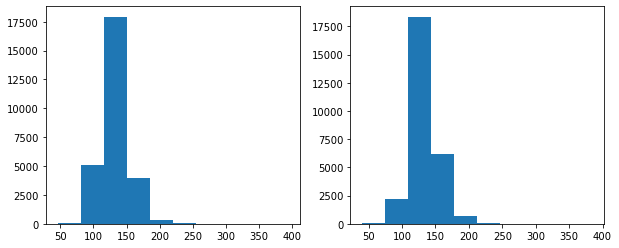

In [ ]:
root = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/"
# rearrange the data for the ease of use
%mkdir data
%mkdir data/cell-images/
for set_ in 'train','test','val':
    os.mkdir('data/cell-images/'+set_)
    for i in 'Parasitized','Uninfected':
        os.mkdir('data/cell-images/'+set_+'/'+str(i))

# find the optimal target size for transformations
hs,ws = [],[]     
for dir_ in 'Parasitized','Uninfected':
    files = glob.glob(root+dir_+'/*.png')
    for item in tqdm(files):
        im = Image.open(item)
        h,w = im.size
        hs.append(h)
        ws.append(w)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(hs)
plt.subplot(1,2,2)
plt.hist(ws)
plt.show()            

In [ ]:
%ls data/cell-images/**

data/cell-images/test:
Parasitized/  Uninfected/

data/cell-images/train:
Parasitized/  Uninfected/

data/cell-images/val:
Parasitized/  Uninfected/


In [ ]:
# copy data
for dir_ in 'Parasitized','Uninfected':
    df = glob.glob(root+dir_+'/*.png')
    length = len(df)
    perm =  np.random.permutation(length)
    df_dict = {'test': perm[0:int(length*0.3)]}
    df_dict['val'] = perm[int(length*0.3):int(length*0.4)]
    df_dict['train'] = perm[int(length*0.4):]
    for set_,perm_ in df_dict.items():
        for i in perm_:
           copyfile(df[i],
                    'data/cell-images/'+set_+'/'+dir_+'/'+os.path.basename(df[i]))

In [ ]:
!ls data/cell-images/test/*/* | cut -d/ -f3-4 | sort | uniq -c
!ls data/cell-images/val/*/* | cut -d/ -f3-4 | sort | uniq -c
!ls data/cell-images/train/*/* | cut -d/ -f3-4 | sort | uniq -c

   4133 test/Parasitized
   4133 test/Uninfected
   1378 val/Parasitized
   1378 val/Uninfected
   8268 train/Parasitized
   8268 train/Uninfected


(133, 139, 3)


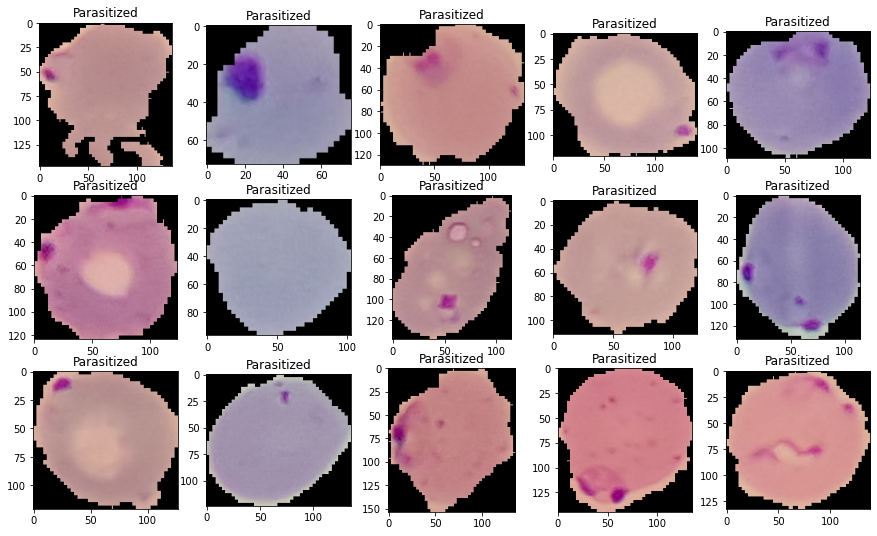

In [ ]:
#@title sample images from the data set
files = glob.glob('data/cell-images/train/*/*.png')
fig, axes = plt.subplots(3,5, figsize=(15,9))
for i,ax in enumerate(axes.flat):
    x = plt.imread(files[i])
    y = files[i].split('/')[-2]
    ax.imshow(x)
    ax.set_title(y)
print(x.shape)

In [ ]:
data_transform = transforms.Compose([
        transforms.Resize((125,125)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_ds = datasets.ImageFolder(root='data/cell-images/train/',
                                           transform=data_transform)
training_generator = torch.utils.data.DataLoader(train_ds,
                                             batch_size=128, shuffle=True)

test_ds = datasets.ImageFolder(root='data/cell-images/test/',
                                           transform=data_transform)
testing_generator = torch.utils.data.DataLoader(test_ds,
                                             batch_size=128, shuffle=True)

val_ds = datasets.ImageFolder(root='data/cell-images/val/',
                                           transform=data_transform)
validation_generator = torch.utils.data.DataLoader(val_ds,
                                             batch_size=128, shuffle=True)

In [ ]:
#@title Manual Data Injection
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv5 = nn.Conv2d(32, 64, 3)
        self.conv7 = nn.Conv2d(64, 128, 3)
        self.conv8 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(10368, 1024)
        self.fc2 = nn.Linear(1024, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)
        x = F.relu(self.fc2(x))
        x = nn.Dropout(p=0.2)(x)        
        x = torch.softmax(self.fc3(x),dim=1)
        return x
    
class CNN5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv5 = nn.Conv2d(32, 64, 5)
        self.conv7 = nn.Conv2d(64, 128, 5)
        self.conv8 = nn.Conv2d(128, 128, 5)
        self.pool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)
        x = F.relu(self.fc2(x))
        x = nn.Dropout(p=0.2)(x)        
        x = torch.softmax(self.fc3(x),dim=1)
        return x

In [ ]:
temp = torch.unsqueeze(data_transform(im),0)
cnn = CNN3()
cnn(temp).shape
cnn = CNN5()
cnn(temp).shape

torch.Size([1, 2])

In [ ]:
opt_functional = lambda x:optim.Adadelta(x.parameters(),lr=.5)
loss_function = nn.CrossEntropyLoss()

In [ ]:
max_epochs = 5
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
cnn_dic = {'cnn3':CNN3(),
           'cnn5':CNN5()}
mdl_pool = {}
for name,cnn in cnn_dic.items():
    print('training '+name)
    optimizer = opt_functional(cnn)
    cnn.to(device)
    train_epoch_loss = [] 
    train_epoch_acc = [] 
    val_epoch_loss = []
    val_epoch_acc = [] 
    for epoch in range(max_epochs):
        cnn.train()
        running_loss = []
        running_acc = []
        for local_batch, local_labels in training_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(local_batch)
            loss = loss_function(outputs, local_labels)
            loss.backward()
            optimizer.step()
            running_loss += [loss.item()]
            _, predicted = torch.max(outputs, 1)
            running_acc += [(predicted == local_labels).sum().item()/training_generator.batch_size]
        train_epoch_loss += [np.mean(running_loss)]
        train_epoch_acc += [np.mean(running_acc)]
        
        running_loss = []
        running_acc = []
        with torch.no_grad():
            cnn.eval()
            for local_batch, local_labels in validation_generator:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                outputs = cnn(local_batch)
                loss = loss_function(outputs, local_labels)
                running_loss += [loss.item()]
                _, predicted = torch.max(outputs, 1)
                running_acc += [(predicted == local_labels).sum().item()/validation_generator.batch_size]

        val_epoch_loss += [np.mean(running_loss)]
        val_epoch_acc += [np.mean(running_acc)]
        print('[{:d}] loss: {:7.5f} - acc: {:%} - val loss: {:7.5f} - val acc: {:%}'.format(epoch + 1,
                                                                                            train_epoch_loss[-1],
                                                                                            train_epoch_acc[-1],
                                                                                            val_epoch_loss[-1],
                                                                                            val_epoch_acc[-1]))
    # evaluate performance on test set
    with torch.no_grad():
        cnn.eval()
        for local_batch, local_labels in testing_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            outputs = cnn(local_batch)
            loss = loss_function(outputs, local_labels)
            running_loss += [loss.item()]
            _, predicted = torch.max(outputs, 1)
            running_acc += [(predicted == local_labels).sum().item()/validation_generator.batch_size]

    test_loss = [np.mean(running_loss)]
    test_acc = [np.mean(running_acc)]
    
    mdl_pool[name]={}
    mdl_pool[name]['loss'] = train_epoch_loss
    mdl_pool[name]['acc'] = train_epoch_acc
    mdl_pool[name]['val_loss'] = val_epoch_loss
    mdl_pool[name]['val_acc'] = val_epoch_acc
    mdl_pool[name]['test_loss'] = test_loss
    mdl_pool[name]['test_acc'] = test_acc

cuda:0
training cnn3
[1] loss: 0.68706 - acc: 54.212740% - val loss: 0.78475 - val acc: 48.934659%
[2] loss: 0.47076 - acc: 83.407452% - val loss: 0.39305 - val acc: 90.092330%
[3] loss: 0.39143 - acc: 91.514423% - val loss: 0.37954 - val acc: 91.335227%
[4] loss: 0.38105 - acc: 92.644231% - val loss: 0.38180 - val acc: 91.086648%
[5] loss: 0.37909 - acc: 92.842548% - val loss: 0.38861 - val acc: 90.518466%
training cnn5
[1] loss: 0.69290 - acc: 50.901442% - val loss: 0.68333 - val acc: 64.204545%
[2] loss: 0.53786 - acc: 76.081731% - val loss: 0.41092 - val acc: 88.281250%
[3] loss: 0.39642 - acc: 91.159856% - val loss: 0.39003 - val acc: 90.305398%
[4] loss: 0.38418 - acc: 92.343750% - val loss: 0.38422 - val acc: 90.873580%
[5] loss: 0.37915 - acc: 92.800481% - val loss: 0.37491 - val acc: 91.938920%


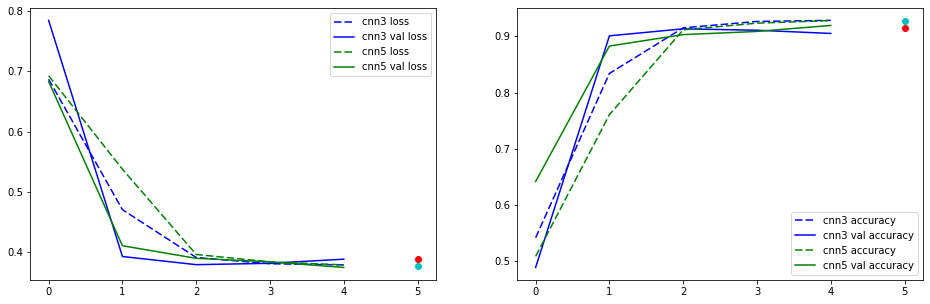

In [ ]:
#@title Plot Training History
plt.figure(figsize=(16,5))
c = ['b', 'g', 'r', 'c']
plt.subplot(121)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['loss'],linestyle=(0,(5,2)),color=c[i],label = name+' loss')
    plt.plot(item['val_loss'],color=c[i],label = name+' val loss')
    plt.scatter(5,item['test_loss'],color=c[i+2])
plt.legend()

plt.subplot(122)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['acc'],linestyle=(0,(5,2)),color=c[i],label = name +' accuracy')
    plt.plot(item['val_acc'],color=c[i],label = name+' val accuracy')
    plt.scatter(5,item['test_acc'],color=c[i+2])
plt.legend()